In [57]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platform = input('Please enter the value for platform: ')

# Read data
data = pd.read_parquet(root + 'DATA/' + platform + '/'+platform+'_raw_data.parquet', columns=columns_to_read[platform])
data.columns=standard_columns
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Dinamiche collettive 

#### 1. Numero di utenti coinvolti in una conversazione

In [59]:
unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index()
unique_users_per_post.columns = ['post_id', 'unique_users_count']
unique_users_per_post.to_csv(root+'PAPER/output/1_section/1_users_in_thread_{}.csv'.format(platform))

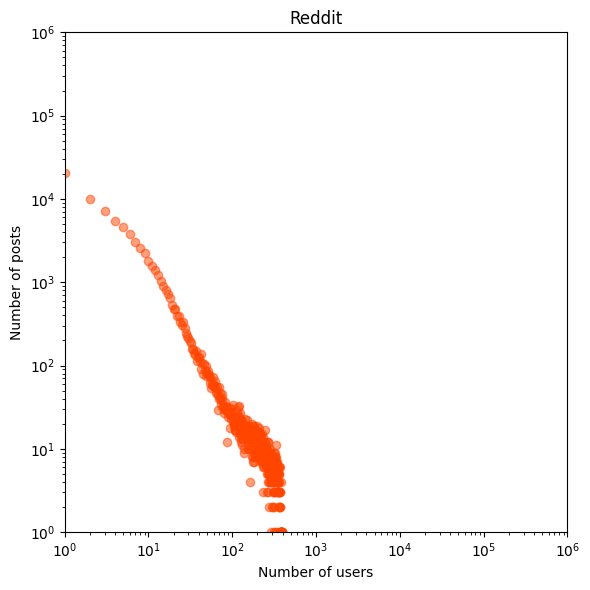

In [60]:
# Assuming the root and platform variables are defined
unique_users_per_post = pd.read_csv(root+'PAPER/output/1_section/1_users_in_thread_{}.csv'.format(platform))
distribution = unique_users_per_post['unique_users_count'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.scatter(distribution.index, distribution.values, color=palette[platform], alpha=0.5)  # Alpha added for transparency
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10**6)  # Set x-axis limits between 1 and 10^6
plt.ylim(1, 10**6)  # Set y-axis limits between 1 and 10^6
plt.xlabel('Number of users')
plt.ylabel('Number of posts')
plt.title(str(platform.capitalize()))
plt.grid(False)
plt.tight_layout()

plt.savefig(root+'PAPER/output/1_section/1_users_in_thread_{}.png'.format(platform))
plt.show()

#### 2. Durata della conversazione

In [61]:


# Esempio di utilizzo: calcolare il 95° percentile e salvare il file
output_path =root+'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
calculate_lifetime_percentile(data, 80, output_path)

Calcolando durata 80° percentile per ogni post: 100%|██████████| 80816/80816 [00:30<00:00, 2613.80it/s]


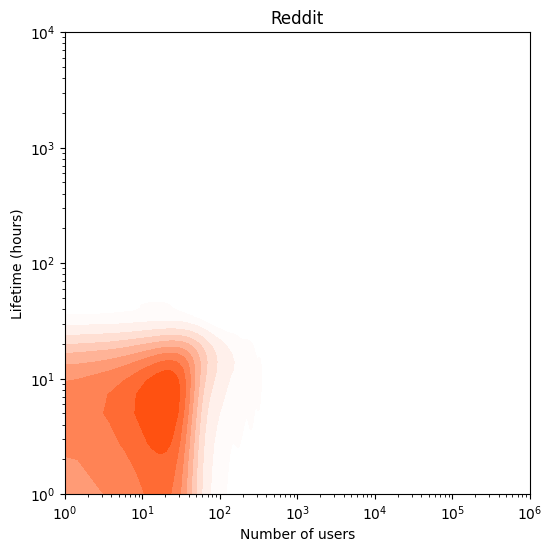

In [62]:

# Load the data
output_path = root + 'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
df = pd.read_csv(output_path, dtype={'post_id': str})

# Remove NA values from the 'duration_percentile' column
df = df.dropna(subset=['duration_percentile','unique_user_count'])
df=df.sample(5000)

# Filter rows where 'unique_user_count' is greater than 50
df = df[df['unique_user_count'] > 10]

# Create the density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(
    data=df, 
    x="unique_user_count",
    y="duration_percentile",  
    fill=True, 
    cmap=LinearSegmentedColormap.from_list("platform_to_white", ['white', palette[platform]])
)
plt.title(str(platform.capitalize()))
plt.ylabel('Lifetime (hours)')
plt.xlabel('Number of users')

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Limit the x-axis between 0 and 10^6, and y-axis between 0 and 10^4
plt.xlim(1, 10**6)
plt.ylim(1, 10**4)


# Save the plot
plt.savefig(root + 'PAPER/output/1_section/2_lifetime_thread_{}.png'.format(platform))
plt.show()


#### 3. Concentration of the conversation

In [63]:
# Conta il numero di utenti univoci per ciascun post
unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index(name='unique_user_count')

# Calcola la concentrazione assoluta massima e relativa dei commenti (come già mostrato)
data['hour'] = data['timestamp'].dt.floor('H')
comments_per_hour = data.groupby(['post_id', 'hour']).size().reset_index(name='comment_count')
max_concentration = comments_per_hour.groupby('post_id')['comment_count'].max().reset_index(name='max_absolute_concentration')

total_comments = data.groupby('post_id').size().reset_index(name='total_comments')
results_df = pd.merge(max_concentration, total_comments, on='post_id')
results_df['relative_concentration'] = results_df['max_absolute_concentration'] / results_df['total_comments']

# Aggiungi il conteggio degli utenti univoci
results_df = pd.merge(results_df, unique_users_per_post, on='post_id')

# Salva il risultato
results_df.to_csv(root+'PAPER/output/1_section/3_concentration_of_comments_{}.csv'.format(platform))


/tmp/ipykernel_778573/2980163939.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['hour'] = data['timestamp'].dt.floor('H')


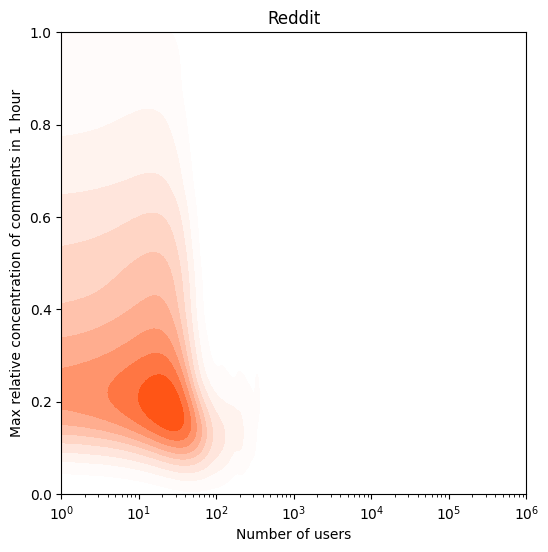

In [64]:
results_df=pd.read_csv(root+'PAPER/output/1_section/3_concentration_of_comments_{}.csv'.format(platform))



filtered_results_df = results_df[results_df['unique_user_count'] > 10]
filtered_results_df=filtered_results_df.sample(5000)
platform_color = palette[platform]  # Ad esempio, il colore arancione che volevi usare

# Definire una scala di colori che parte da 'platform_color' e termina con il bianco
cmap = LinearSegmentedColormap.from_list("platform_to_white", [ 'white',platform_color])

# Supponiamo che il tuo dataframe si chiami 'filtered_results_df'
plt.figure(figsize=(6, 6))
sns.kdeplot(x=filtered_results_df['unique_user_count'], y=filtered_results_df['relative_concentration'], cmap=cmap, fill=True)

plt.title(str(platform.capitalize()))
plt.ylabel('Max relative concentration of comments in 1 hour')
plt.xlabel('Number of users')
plt.xscale('log')
plt.xlim(1, 10**6)
plt.ylim(0,1)
plt.grid(False)

plt.savefig(root+'PAPER/output/1_section/3_concentration_of_comments_{}.png'.format(platform))
plt.show()


#### 4. Level of dialogue

In [65]:
grouped = data.groupby(['user_id', 'post_id']).size().reset_index(name='comment_count')
user_count = data.groupby('post_id')['user_id'].nunique().reset_index(name='user_count')
result = grouped.merge(user_count, on='post_id', how='left')
bins = np.arange(0, 1020, 50)
result['user_count_bin'] = pd.cut(result['user_count'], bins=bins, right=False)
valid_bins = result['user_count_bin'].value_counts()[result['user_count_bin'].value_counts() > 10].index
result = result[result['user_count_bin'].isin(valid_bins)]
result['comment_count'] = result['comment_count'].apply(lambda x: 5 if x > 5 else x)
prob_dist = result.groupby(['user_count_bin', 'post_id'])['comment_count'].value_counts(normalize=True)

localization_results = prob_dist.groupby(['user_count_bin', 'post_id']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')
localization_results.to_csv(root + f'PAPER/output/1_section/4_dialogue_level_{platform}.csv')

/tmp/ipykernel_778573/2549383739.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_dist = result.groupby(['user_count_bin', 'post_id'])['comment_count'].value_counts(normalize=True)
/tmp/ipykernel_778573/2549383739.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  localization_results = prob_dist.groupby(['user_count_bin', 'post_id']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')


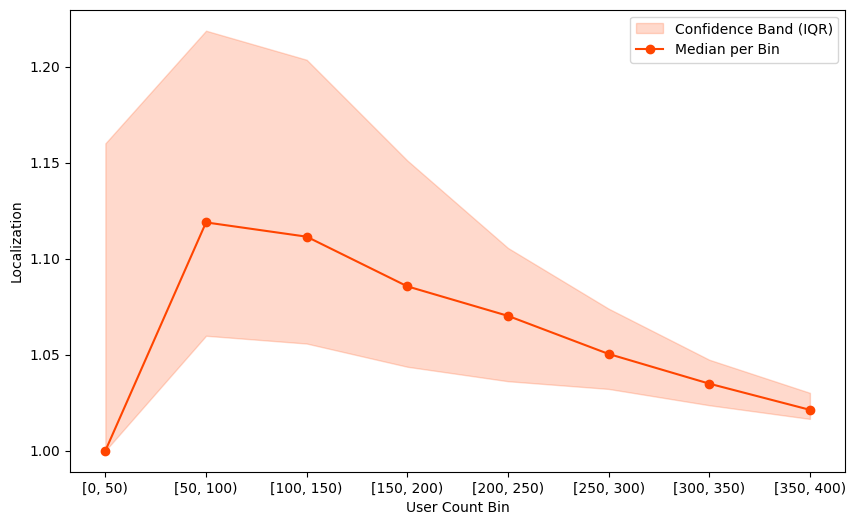

In [ ]:
# Load the data
localization_results = pd.read_csv(f"{root}PAPER/output/1_section/4_dialogue_level_{platform}.csv")

# Group data by 'user_count_bin' and calculate median, Q1, and Q3 for 'localization_parameter'
median_values = localization_results.groupby('user_count_bin')['localization_parameter'].median().reset_index()
q1_values = localization_results.groupby('user_count_bin')['localization_parameter'].quantile(0.25).reset_index()
q3_values = localization_results.groupby('user_count_bin')['localization_parameter'].quantile(0.75).reset_index()

# Merge median, Q1, and Q3 values into a single DataFrame
conf_interval = pd.merge(median_values, q1_values[['user_count_bin', 'localization_parameter']], on='user_count_bin', suffixes=('', '_Q1'))
conf_interval = pd.merge(conf_interval, q3_values[['user_count_bin', 'localization_parameter']], on='user_count_bin', suffixes=('', '_Q3'))

# Sort values by 'user_count_bin' (converting to numeric if necessary)
localization_results['bin_lower_bound'] = localization_results['user_count_bin'].str.extract(r'(\d+)').astype(float)
conf_interval = conf_interval.merge(localization_results[['user_count_bin', 'bin_lower_bound']].drop_duplicates(), on='user_count_bin')
conf_interval = conf_interval.sort_values(by='bin_lower_bound').reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.fill_between(conf_interval['user_count_bin'], conf_interval['localization_parameter_Q1'], conf_interval['localization_parameter_Q3'], color=palette[platform], alpha=0.2, label='Confidence Band (IQR)')
plt.plot(conf_interval['user_count_bin'], conf_interval['localization_parameter'], marker='o', color=palette[platform], label='Median per Bin')

# Add labels and legend
plt.xlabel('User Count Bin')
plt.ylabel('Localization')
plt.legend()
plt.savefig(root+'PAPER/output/1_section/4_dialogue_level_{}.png'.format(platform))
plt.show()